In [165]:
import numpy as np
import math
import json

def waveforms(N_A, N_g, N_f, t0_tf, T, B, trials, filename, phi0=0, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N=1000):
    
    # initalizes the arrays which span parameter space, and their lengths
    A_RANGE=np.linspace(A0,Af,N_A)
    G_RANGE=np.linspace(g0,gf,N_g)
    F_RANGE=np.linspace(F0,Ff,N_f)
    
    A_LEN, G_LEN, F_LEN = len(A_RANGE), len(G_RANGE), len(F_RANGE)
    
    waveform_data={}
    for j in range(trials):
        waveform_data.update({j:[[],[]]})
        
        #calculates random parameters A, f, g
        A_RAN=np.random.randint(0,A_LEN)
        G_RAN=np.random.randint(0,G_LEN)
        F_RAN=np.random.randint(0,F_LEN)

        f, A, gamma = F_RANGE[F_RAN], A_RANGE[A_RAN],  G_RANGE[G_RAN] 

        dt=T/N

        NOISE = -B+2*B*np.random.random(N)  # Noise!

        t0=(T-t0_tf)*np.random.random(1)[0]  # Randomly generate start time
        START_INDEX=math.floor(t0/dt)        # find index associated with time

        ##NOTE: using 't0' instead of some multiple of dt may cause issues later

        SIG_LEN =( math.floor(t0_tf/dt)+1 if (t0_tf != T) else N )      # Calculate # of indexes signal takes
        INJECTED = np.zeros(N)                       #initalize injected signal
        for i in range(SIG_LEN):
            INJECTED[ START_INDEX + i]=t0+i*dt       #fill in injected signal

        w = 2 * np.pi * f

        SR = INJECTED[ START_INDEX : START_INDEX+SIG_LEN][:]
        INJECTED[ START_INDEX : START_INDEX+SIG_LEN] = A*np.sin(w*SR + phi0)*np.exp(-gamma*( SR-t0))
        D_i = NOISE + INJECTED  # Complete Data!
        
        # Gets parameters and data for each trial, stuffs it into dictionary
        parameters = [A, f, gamma, t0]
        waveform_data[j][0], waveform_data[j][1] = parameters, list(D_i)
    
    with open("{}-waveform_data.json".format(filename) , "w") as f:
        json.dump(waveform_data, f, indent=2, sort_keys=True)


In [166]:
#N_A, N_g, N_f, t0_tf, T, B, trials, filename, phi=0, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N=1000, filename=None):
waveforms(4, 4, 4, 4, 10, 4, 10,"test",N=250)

In [167]:
import json
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
import time

class OnSource:
    
    def __init__(self, N_A, N_g, N_f, t0_tf, T, b, D, trials, filename, A0=1, Af=50, g0=0, gf=2, F0=90, Ff=110, N_t=1000):

        print('very start...')
        """
        METHOD: 
        Generates a set of wave templates spanning the parameter space of amplitude, frequency and gamma;
        Generates a set of datasets with injected signals via random A, f, gamma, and start time
        Creates cross-correlation/chi-squared stats with the above
        Lastly, saves the above internally as attributes, and externally as a .json file
        
        PARAMETERS:
        -----------
        N_A: divisions in amplitude
        N_g:  divisions in gamma
        N_f: divisions in frequency
        t0_tf: length of template interval [t0, tf] in time
        T: length of total time series, in units of time
        b: noise amplitude
        D: foreground/background interval length
        trials: number of random data sets generated
        A0, Af : amplitude lower/upper bounds
        g0, gf : gamma lower/upper bounds
        F0, ff : frequency lower/upper bounds
        N_t= divisions in total time series 
        
        OUTPUT: Returns global maximum values for given ranges, and produces txt
        value containing all of them
        """
        
        
        print('initalizing output...')
        """initalizes a dictionary of arrays to hold info and later save as a .json
        key i: returns an array of arrays containing datset i and other relavent values
                component 0: true A, f & g corresoponding to dataset i
                component 1: dataset i
                component 2: cross corelations between dataset and each template
                component 3: chi squares between dataset and each template
        """
        self.trials=trials
        output={}
        for i in range(self.trials):
            output.update({i:[[],[],[],[]]})
        
        print('initalizing attributes...')
        # initalizes the arrays which span parameter space, and their lengths
        self.A_RANGE=np.linspace(A0,Af,N_A)
        self.G_RANGE=np.linspace(g0,gf,N_g)
        self.F_RANGE=np.linspace(F0,Ff,N_f)
        
        self.A_LEN, self.G_LEN, self.F_LEN = len(self.A_RANGE), len(self.G_RANGE), len(self.F_RANGE)
        
        self.N=N_t
        
        # Constructs timestep resolution, and saves t0/tf internally 
        self.dt, self.t0_tf= T/N_t, t0_tf
        
        # constructs time range to pick injected signal start time from/ corresponding length 
        self.t_RANGE=np.linspace(0,T-(t0_tf),int(N_t*(1-((t0_tf)/(T)))))
        self.t_LEN=len(self.t_RANGE)

        # initialize arrays for various data/cross-correlations/chi-squares 
        self.noise = []
        self.cross_cor=[]
        self.chi=[]
        
        
        
        print('building pairs/templates...')
        # constructs all templates which correspond to points in the parameter space
        self.TEMPLATES_AFG=[ self.template( A, f, g, t0_tf, self.dt) for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]
        
        self.AFG_PAIR=[ [A, f, g] for A in self.A_RANGE 
                       for g in self.G_RANGE for f in self.F_RANGE]

        print('starting data/template loop...')
        
        # Opens waveform data file # NEW ADDITION
        with open("{}-waveform_data.json".format(filename),"r") as f: 
            waveform_data = json.load(f)
        
        for i in range(trials):            
            
            # generates data # NEW ADDITION
            temp_AGFT, data = waveform_data[str(i)][0], waveform_data[str(i)][1]
            
            self.noise.append(data) 
            output[i][0], output[i][1] = temp_AGFT, data  ## stores random a-g-f pair / data set 
            
            
            CRS_COR, CHI_SQR = [[],[]]
            
            # performs base static calculation accross parameter space
            for template in self.TEMPLATES_AFG:
            
                CC_dh=list(self.CrossCorrelation(data, template, self.dt))
                CRS_COR.append(CC_dh)
                                            
                CS_dh=list(self.ChiSquare(data, template, self.dt))
                CHI_SQR.append(CS_dh)
            
            #stores base statistics in appropriate attribute/ output
            self.cross_cor.append(CRS_COR)
            self.chi.append(CHI_SQR)
            output[i][2], output[i][3] = CRS_COR, CHI_SQR
        
        #sets output as a attribute
        self.output=output
        
        #saves 'output' as a .json in current working directory.
        '''with open('outputfile', "w") as f:
            json.dump(output, f, indent=2, sort_keys=True)'''
    
    
    
    
            



    
    
    
    #calculates test statistic, stroes it internally,
    #and returns a copy of it as a dictionary 
    def rho(self):
        #counts number of tempates in parameter space
        PSPACE_LEN=len(self.AFG_PAIR)
    
        #initalizes rho statistic dictionary
        self.RHO={}
    
        #indexed to loops through dataset trials
        for i in range(self.trials):
            rho_i=[]
        
            #indexed to loops through parameter space templates and
            #calculates each rho_ij given template j
            for j in range(PSPACE_LEN):
                CC_IJ=np.array(self.cross_cor[i][j][:])
                CS_IJ=np.array(self.chi[i][j][:])
                
                            ##1. function_input="f(CC,CS)"
                            ##2. exec("p="+function_input)
                            ##3. rho_i.append( list( p )) )
                            ##4. ...
                            ##5. profit?
                            
                rho_i.append( list( (CC_IJ/(1+CS_IJ) )) ) 
            
            self.RHO.update({ i : rho_i })
        
        return self.RHO

    
    
    
    
    def modulator(self, rho_ij, D):
       
        rho_mod_D, RHO_ij = [] , rho_ij[:]
    
        dn , L = math.floor(2*D/self.dt) , len(RHO_ij)

        for i in range(0,L-(L%dn),dn):
            rho_mod_D.append(max(RHO_ij[i:i+dn]))
        
        if (L-(L%dn)) != L :
            rho_mod_D.append(max(RHO_ij[L-(L%dn):L]))
        
        return rho_mod_D
    
    
    
    
    
    def window(self, D):
        
        if (2*D >= self.dt):
            
            print('initalizing output...')
            """Build a dictionary of arrays that hold rho off-source/on-source values
            key i: returns ndim-arrays containing rho statistics of dataset_i
                component [0][j]: returns off-source array for template j
                component [1][j]: returns on-source scalar for template j
            """
            self.RHO_MOD={}
        
            for i in range(self.trials):
    
                #gets the length
                TEMP_LEN=len(self.cross_cor[i])
    
                #calculates bg values + fg values
                BG_VALS_IJ=[self.modulator( self.RHO[i][j][:] ,D ) for j in range(TEMP_LEN)]
            
                #seperates fg value from bg value
                T0_2D=math.floor(self.output[i][0][3]/(2*D))
            
                print("t0: "+str(self.output[i][0][3])+"  T0_2D: "+str(T0_2D))
            
                FG_VAL_IJ=[ BG_VALS_IJ[j].pop(T0_2D) for j in range(TEMP_LEN)]
    
                self.RHO_MOD.update({ i: [ BG_VALS_IJ, FG_VAL_IJ ] })
        

            return self.RHO_MOD
        
        else: 
            print("invalid D; it is required that 2*D >= T/N")
    
    
    
    
    def test_plotter(self, T, N, index=0):
        
        mapping={}

        holder=np.full((self.F_LEN, self.A_LEN, self.G_LEN), 0, dtype=list)

        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    A=self.F_RANGE[i]
                    F=self.A_RANGE[k]
                    G=self.G_RANGE[j]
            
                    holder[(i,j,k)]=[0]
                    mapping.update({ (A,F,G) : holder[(i,j,k)]})
        
        
        #initalizes threshold axis points, counts for each threshold
        #and space of parameter space
        THRS_AXIS=[]
        COUNT_AXIS=[]
        PSPACE_LEN=len(self.AFG_PAIR)
        PSACE_PAIRS=[]

        #sets current threshold value
        for thrshld in np.linspace(0,T,N):

            THRS_AXIS.append(thrshld)
            succ_count_thrhld=0
        
            #loops from trial/ parameter space pairs 
            for i in range(self.trials):
                heat_count=0
                for j in range(PSPACE_LEN):
                
                    RM_ij=np.array(self.RHO_MOD[i][0][j])
                    FG_ij=self.RHO_MOD[i][1][j]
                    N_BG_ij=len(RM_ij[ RM_ij > FG_ij])
                
                    #tests if the given pair passes the threshold test
                    if ((N_BG_ij==0) and (FG_ij > thrshld)):
                    
                    
                        if heat_count==0:
                            succ_count_thrhld+=1
                            mapping[tuple(self.output[i][0][:3])][0]+=1
                            heat_count+=1
        
            COUNT_AXIS.append(succ_count_thrhld)
        
        plt.plot(THRS_AXIS,COUNT_AXIS)
        plt.xlabel("$Threshold$")
        plt.ylabel("Counts")
        plt.show()
        
        for j in range(self.F_LEN):
            for i in range(self.A_LEN):
                for k in range(self.G_LEN):
                    holder[(i,j,k)]=holder[(i,j,k)][0]
        
        w=holder.sum(index)
        
        cop=np.full(w.shape,0)
        z=[(i,j) for i in range(w.shape[0]) for j in range(w.shape[1])]
        for tup in z:
            cop[tup]=int(w[tup])

        plt.imshow( cop, cmap=plt.cm.hot) 
    
        #plt.imshow( heat_array, cmap=plt.cm.hot) 
    
    
    
    
    def Scatter_plotter(self, thrshld, xvar, yvar): 
    
        label=["frequency", "amplitude", "gamma"]
        PSPACE_LEN=len(self.AFG_PAIR)
        SUCC_PAIRS=([],[])
        FAIL_PAIRS=([],[])

        #loops from trial/ parameter space pairs 
        for i in range(self.trials):
        
            succ_count_thrhld=0  #test condition for adding to fail array

            for j in range(PSPACE_LEN):
            
                RM_ij=np.array(self.RHO_MOD[i][0][j])  #get moded rho_ij background values
                FG_ij=self.RHO_MOD[i][1][j]            #get moded rho_ij foreground value
                N_BG_ij=len(RM_ij[ RM_ij > FG_ij])     # get background vals > froeground vals
                
                #tests if the given pair passes the threshold test
                if ((N_BG_ij==0) and (FG_ij > thrshld)):
                
                    parameter_x=self.output[i][0][xvar]  #get parameter 'xvar' of trial i
                    parameter_y=self.output[i][0][yvar]  #get parameter 'yvar' of trial i
                    SUCC_PAIRS[0].append(parameter_x) #add to successes
                    SUCC_PAIRS[1].append(parameter_y)
                    succ_count_thrhld+=1
                    break
        
            #sees if trial i failed the test; adds parameters to fail array
            if succ_count_thrhld==0:
                parameter_x=self.output[i][0][xvar]
                parameter_y=self.output[i][0][yvar]
                FAIL_PAIRS[0].append(parameter_x)
                FAIL_PAIRS[1].append(parameter_y)
    
        colors = ("red", "blue")
        groups = ("pass", "fail")
        marks = ("o", "*")
        data = ( SUCC_PAIRS, FAIL_PAIRS )
    
        # Create plot
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        for data, marks, color, group in zip(data, marks, colors, groups):
            x , y = data
            ax.scatter(x, y, marker=marks, c=color, edgecolors='none', s=30, label=group)

        plt.title('found-missed plot')
        plt.xlabel(label[xvar])
        plt.ylabel(label[yvar])
        plt.legend(loc=2)
        plt.show()
    
    
    
    # Produces a template given a position in parameter space
    def template(self, A, f, gamma, duration, dt):
        t = np.arange(0, duration + dt, dt)
        w = 2 * np.pi * f
        return A * np.sin(w*t)*np.exp(-gamma*t)
    
    
    
    
    # Produces a cross corelation function given a data input and a template in parameter space
    def CrossCorrelation(self, data, template, dt):
        ii = 0
        M = []
        
        while len(data[ii:]) >= len(template):
            M.append(np.sum((data[ii: len(template) + ii] * template)))
            ii+=1
        
        return M
                                            
    
    

    # Produces chi square at each "slide"
    def ChiSquare(self, data, template, dt):
        ii = 0
        C = []
        
        while len(data[ii:]) >= len(template):
            C.append(np.sum((data[ii: len(template) + ii] - template) ** 2))
            ii += 1
            
        return C

In [168]:
x=OnSource(4, 4, 4, 4, 10, 4, 0.3, 10,"test",N_t=250)#N_A, N_g, N_f, t0_tf, T, b, D, trials, N_t

very start...
initalizing output...
initalizing attributes...
building pairs/templates...
starting data/template loop...


Trial 0:   [frequency, amp, gamma, t0] = [17.333333333333332, 90.0, 0.0, 1.6172697785787202]


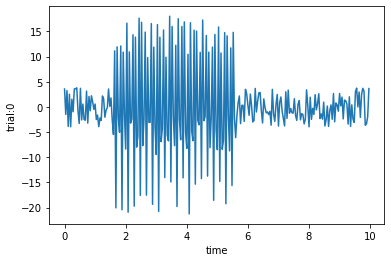

Trial 1:   [frequency, amp, gamma, t0] = [33.666666666666664, 90.0, 1.3333333333333333, 2.7909800488787395]


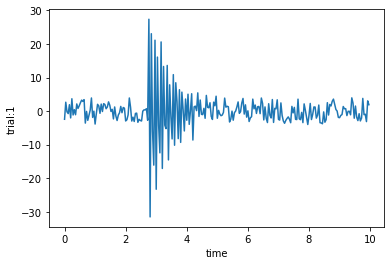

Trial 2:   [frequency, amp, gamma, t0] = [33.666666666666664, 96.66666666666667, 2.0, 3.6639203899417394]


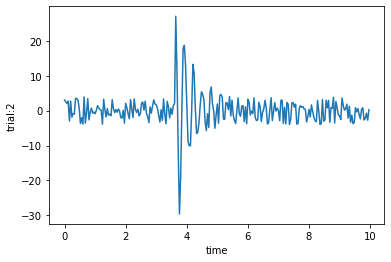

Trial 3:   [frequency, amp, gamma, t0] = [1.0, 96.66666666666667, 2.0, 1.9422563565635724]


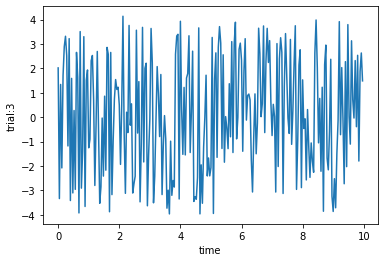

Trial 4:   [frequency, amp, gamma, t0] = [33.666666666666664, 110.0, 2.0, 0.006552566259446557]


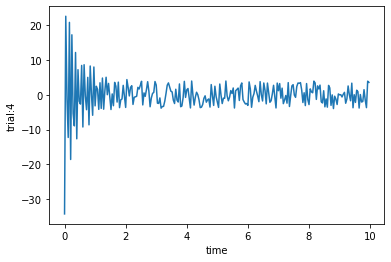

Trial 5:   [frequency, amp, gamma, t0] = [33.666666666666664, 90.0, 2.0, 4.789494836951068]


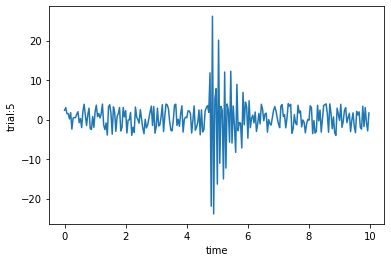

Trial 6:   [frequency, amp, gamma, t0] = [50.0, 96.66666666666667, 0.6666666666666666, 2.213837685233946]


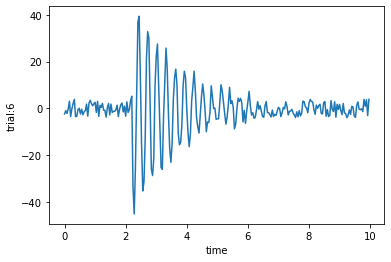

Trial 7:   [frequency, amp, gamma, t0] = [17.333333333333332, 110.0, 2.0, 2.0331144486555504]


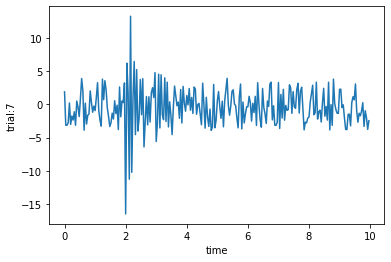

Trial 8:   [frequency, amp, gamma, t0] = [1.0, 110.0, 1.3333333333333333, 5.88124707136061]


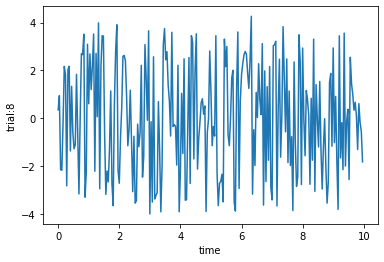

Trial 9:   [frequency, amp, gamma, t0] = [33.666666666666664, 90.0, 1.3333333333333333, 3.8988031650799435]


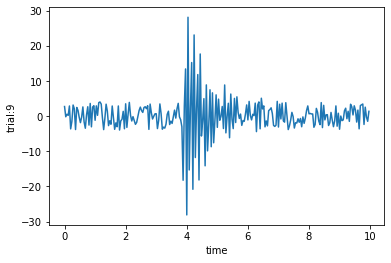

In [169]:
from matplotlib import pyplot as plt
%matplotlib inline

xaxis=[10/x.N*j for j in range(x.N)] 
for i in range(x.trials):
    print("Trial "+str(i)+":   [frequency, amp, gamma, t0] = "+str(x.output[i][0]))
    plt.plot(xaxis, x.output[i][1])
    plt.xlabel("time")
    plt.ylabel("trial:" +str(i))
    plt.show()

In [170]:
#builds rho statistic
y=x.rho()

In [171]:
#performs modulation/ bg-fg value finding on rho
z=x.window(.02)

initalizing output...
t0: 1.6172697785787202  T0_2D: 40
t0: 2.7909800488787395  T0_2D: 69
t0: 3.6639203899417394  T0_2D: 91
t0: 1.9422563565635724  T0_2D: 48
t0: 0.006552566259446557  T0_2D: 0
t0: 4.789494836951068  T0_2D: 119
t0: 2.213837685233946  T0_2D: 55
t0: 2.0331144486555504  T0_2D: 50
t0: 5.88124707136061  T0_2D: 147
t0: 3.8988031650799435  T0_2D: 97


In [173]:
#plots threshold vs. success-count
w=x.test_plotter(8,100)

KeyError: (17.333333333333332, 90.0, 0.0)

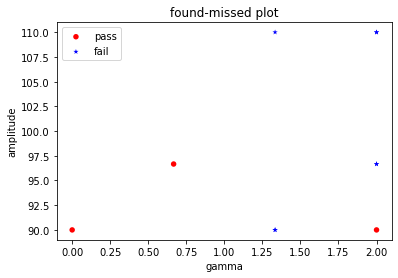

In [174]:
#scatter plot of fails & passes given threshold t
# Amplitude vs. gamma
x.Scatter_plotter( 1.5, 2, 1)

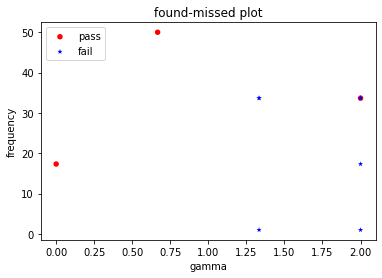

In [175]:
#scatter plot of fails & passes given threshold t
# Amplitude vs. frequency
x.Scatter_plotter( 1.5, 2, 0)

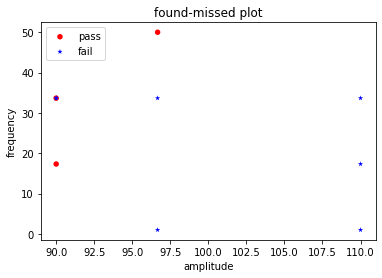

In [176]:
#scatter plot of fails & passes given threshold t
# frequency vs. gamaa
x.Scatter_plotter( 1.5, 1, 0)